In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import copy
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from thesis_tools.utils.data import *
from thesis_tools.statistical_tests.test_statistics import *
from thesis_tools.models.frequentist import *

# Figure 2

In [2]:
years = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', 
         '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', 
         '2019', '2020', '2021']
df = read_billionaires_data(
    only_years=years
)

In [3]:
# Make a new dictionary
# For each sub_region in a year, calculate the R_stat on the log_net_worth data
sub_regions = df['sub_region'].unique()
sub_regions = sub_regions[sub_regions != 'Not a sub-region']

sub_region_year_dict = {}
for region in sub_regions:
    for year in years:
        # Get the data for a given sub_region and year
        data = df[(df['sub_region'] == region) & (df['year'] == year)]['log_net_worth']
        n = len(data)
        R_2 = R_stat(data, order=2)
        R_3 = R_stat(data, order=3)
        sub_region_year_dict[f"{region}_{year}"] = {
            'R_2': R_2,
            'R_3': R_3,
            'n_obs': n
        }
sub_region_year_df = pd.DataFrame(sub_region_year_dict).T

# calculate population weights
sub_region_year_df['weight'] = sub_region_year_df['n_obs'] / sub_region_year_df['n_obs'].mean()

In [4]:
sub_region_year_df

,R_2,R_3,n_obs,weight
U.S._2001,0.899578,0.736349,182.0,2.859589
U.S._2002,0.961052,0.852251,176.0,2.765317
U.S._2003,0.974762,0.857957,165.0,2.592485
U.S._2004,0.939332,0.816880,211.0,3.315238
U.S._2005,0.953098,0.851972,261.0,4.100840
...,...,...,...,...
South Korea_2017,0.979079,0.867912,38.0,0.597057
South Korea_2018,0.945845,0.801477,44.0,0.691329
South Korea_2019,0.982714,0.864498,40.0,0.628481
South Korea_2020,1.055636,0.980645,28.0,0.439937


In [5]:
# Filter DataFrame where 'n_obs' >= 64
sub_region_year_df_n64 = copy.deepcopy(sub_region_year_df[sub_region_year_df['n_obs'] >= 64])

# Remove top and bottom 5% of observations in terms of the R_2 statistic
lower_bound_R2 = sub_region_year_df_n64['R_2'].quantile(0.05)
upper_bound_R2 = sub_region_year_df_n64['R_2'].quantile(0.95)
sub_region_year_df_n64_r2_trimmed = copy.deepcopy(sub_region_year_df_n64[(sub_region_year_df_n64['R_2'] >= lower_bound_R2) & (sub_region_year_df_n64['R_2'] <= upper_bound_R2)])

# Normalize the weight column
sub_region_year_df_n64_r2_trimmed.loc[:, 'weight'] = sub_region_year_df_n64_r2_trimmed['weight'] / sub_region_year_df_n64_r2_trimmed['weight'].mean()

# Do the same for the R_3 statistic
lower_bound_R3 = sub_region_year_df_n64['R_3'].quantile(0.05)
upper_bound_R3 = sub_region_year_df_n64['R_3'].quantile(0.95)
sub_region_year_df_n64_r3_trimmed = copy.deepcopy(sub_region_year_df_n64[(sub_region_year_df_n64['R_3'] >= lower_bound_R3) & (sub_region_year_df_n64['R_3'] <= upper_bound_R3)])

# Normalize the weight column
sub_region_year_df_n64_r3_trimmed.loc[:, 'weight'] = sub_region_year_df_n64_r3_trimmed['weight'] / sub_region_year_df_n64_r3_trimmed['weight'].mean()


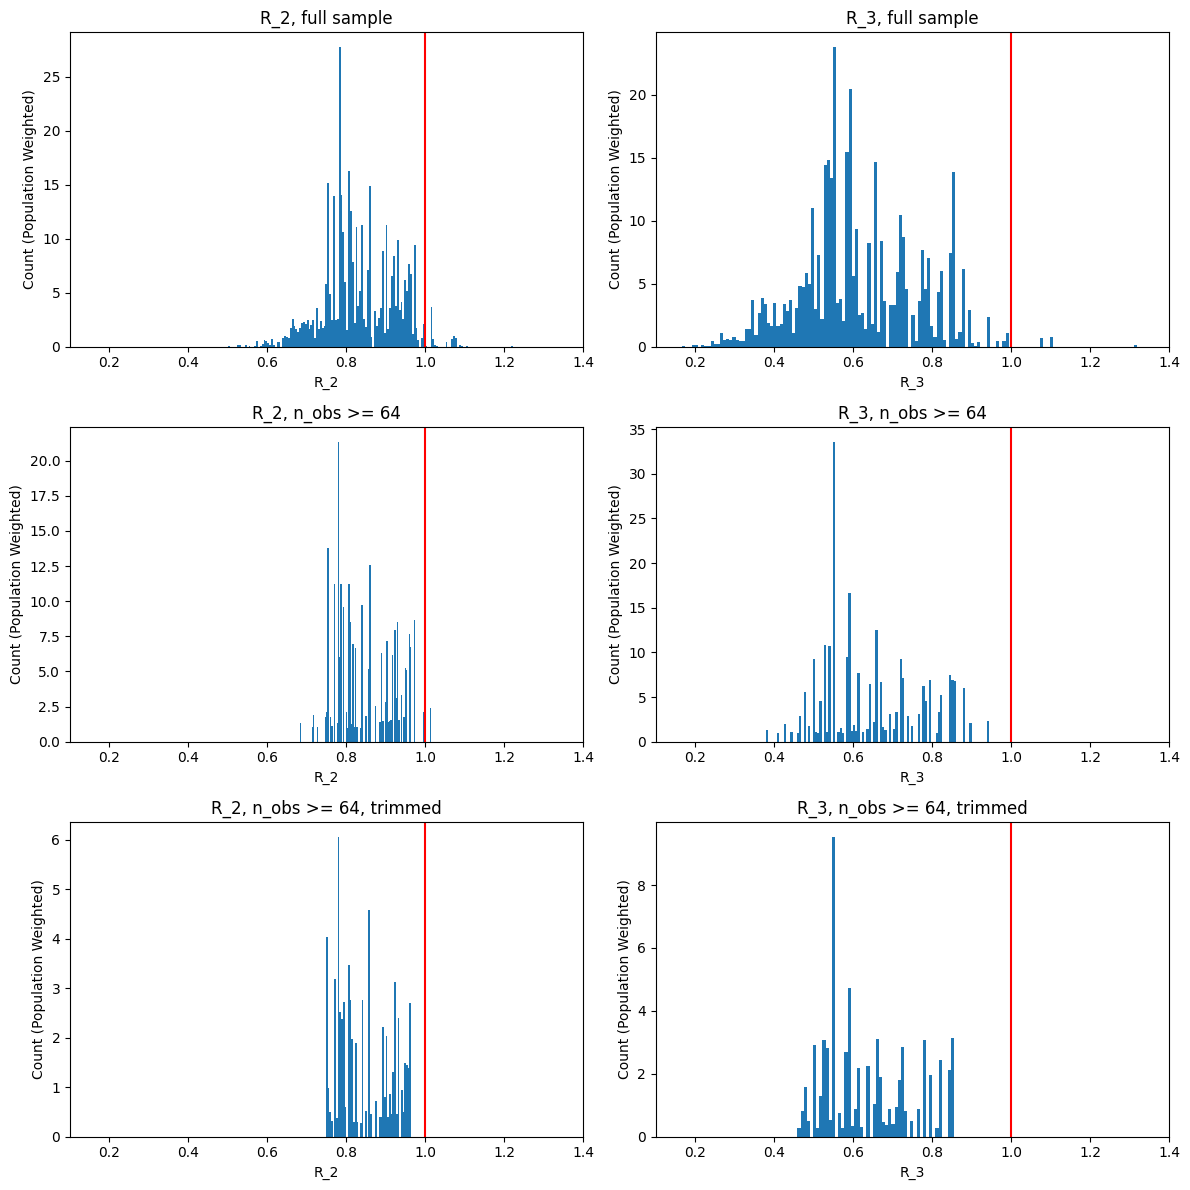

In [6]:
# Make the following 6 histograms in a 3x2 grid
# (a) R_2, full sample
# (b) R_3, full sample
# (c) R_2, n_obs >= 64
# (d) R_3, n_obs >= 64
# (e) R_2, n_obs >= 64, trimmed
# (f) R_3, n_obs >= 64, trimmed
# x axis always between 0.1 and 1.4, step size 0.1
# vertical red line at 1.0
n_bins_a_b = 200
n_bins_c_d = 100
n_bins_e_f = 50
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
# Plot (a)
axs[0, 0].hist(sub_region_year_df['R_2'], bins=n_bins_a_b, weights=sub_region_year_df['weight'])
axs[0, 0].set_title('R_2, full sample')
axs[0, 0].set_xlabel('R_2')
axs[0, 0].set_ylabel('Count (Population Weighted)')
axs[0, 0].set_xlim(0.1, 1.4)
axs[0, 0].axvline(x=1.0, color='red')
# Plot (b)
axs[0, 1].hist(sub_region_year_df['R_3'], bins=n_bins_a_b, weights=sub_region_year_df['weight'])
axs[0, 1].set_title('R_3, full sample')
axs[0, 1].set_xlabel('R_3')
axs[0, 1].set_ylabel('Count (Population Weighted)')
axs[0, 1].set_xlim(0.1, 1.4)
axs[0, 1].axvline(x=1.0, color='red')
# Plot (c)
axs[1, 0].hist(sub_region_year_df_n64['R_2'], bins=n_bins_c_d, weights=sub_region_year_df_n64['weight'])
axs[1, 0].set_title('R_2, n_obs >= 64')
axs[1, 0].set_xlabel('R_2')
axs[1, 0].set_ylabel('Count (Population Weighted)')
axs[1, 0].set_xlim(0.1, 1.4)
axs[1, 0].axvline(x=1.0, color='red')
# Plot (d)
axs[1, 1].hist(sub_region_year_df_n64['R_3'], bins=n_bins_c_d, weights=sub_region_year_df_n64['weight'])
axs[1, 1].set_title('R_3, n_obs >= 64')
axs[1, 1].set_xlabel('R_3')
axs[1, 1].set_ylabel('Count (Population Weighted)')
axs[1, 1].set_xlim(0.1, 1.4)
axs[1, 1].axvline(x=1.0, color='red')
# Plot (e)
axs[2, 0].hist(sub_region_year_df_n64_r2_trimmed['R_2'], bins=n_bins_e_f, weights=sub_region_year_df_n64_r2_trimmed['weight'])
axs[2, 0].set_title('R_2, n_obs >= 64, trimmed')
axs[2, 0].set_xlabel('R_2')
axs[2, 0].set_ylabel('Count (Population Weighted)')
axs[2, 0].set_xlim(0.1, 1.4)
axs[2, 0].axvline(x=1.0, color='red')
# Plot (f)
axs[2, 1].hist(sub_region_year_df_n64_r3_trimmed['R_3'], bins=n_bins_e_f, weights=sub_region_year_df_n64_r3_trimmed['weight'])
axs[2, 1].set_title('R_3, n_obs >= 64, trimmed')
axs[2, 1].set_xlabel('R_3')
axs[2, 1].set_ylabel('Count (Population Weighted)')
axs[2, 1].set_xlim(0.1, 1.4)
axs[2, 1].axvline(x=1.0, color='red')
plt.tight_layout()
plt.show()





# Table 5

In [7]:
df = read_billionaires_data(only_years=years)
# Make a new dictionary
# For each sub_region in a year, calculate the R_stat on the log_net_worth data
sub_regions = df['sub_region'].unique()
sub_regions = sub_regions[sub_regions != 'Not a sub-region']

weibull_gammas = []
for region in sub_regions:
    for year in years:
        # Get the data for a given sub_region and year
        data = df[(df['sub_region'] == region) & (df['year'] == year)]['log_net_worth']
        if len(data) < 64:
            continue
        # Fit the gompertz distribution to the data
        gompertz_dist = Gompertz()
        gamma, alpha = gompertz_dist.fit(data)
        weibull_gammas.append(gamma)

In [8]:
median_gamma = np.median(weibull_gammas)
median_gamma = round(median_gamma, 3)
median_gamma

0.282

In [9]:
df = read_billionaires_data(only_years=['2018'])

# Fit a Pareto distribution to all the sub_regions in 2018
# Group the data by sub_region
grouped = df.groupby('sub_region')
sub_region_pareto_params = {}
for name, group in grouped:
    data = group['net_worth']

    # Pareto estimation
    pareto_dist = Pareto()
    alpha_pareto, x_m = pareto_dist.fit(data)

    # Weibull estimation
    log_data = np.log(data)
    gompertz_dist = Gompertz()
    gamma_gompertz, alpha_gompertz = gompertz_dist.fit(log_data, given_gamma=median_gamma)

    # Store the results
    sub_region_pareto_params[name] = {
        'Mean_Wealth_Data': data.mean(),
        'Mean_Wealth_Weibull': Weibull(gamma=gamma_gompertz, alpha=alpha_gompertz).mean(),
        'Mean_Wealth_Pareto': pareto_dist.mean(),
        'Alpha_Weibull': alpha_gompertz,
        'Alpha_Pareto': alpha_pareto
    }

    print(Weibull(gamma=gamma_gompertz, alpha=alpha_gompertz).mean())

# Make a DataFrame
sub_region_pareto_params_df = pd.DataFrame(sub_region_pareto_params).T
sub_region_pareto_params_df = sub_region_pareto_params_df.reindex([
    'U.S.', 'Canada', 'Germany', 'British Islands', 'Scandinavia', 'France',
    'Alps', 'Italy', 'China', 'Southeast Asia', 'Japan', 'Asian Islands', 'South Korea',
    'Japan', 'Australia', 'India', 'Russia', 'Brazil', 'Israel + Turkey'
])

Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
4.65669558013055
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
3.2165681102168704
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
2.746742860077445
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
4.415471028044261
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
4.260092909722021
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
3.2163852600471503
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
3.0996768136222603
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
8.118142877092476
Gamma parameter set to: None using given_gamma to esti

In [10]:
df_rounded = sub_region_pareto_params_df.round(2)

In [11]:
sub_regions

array(['U.S.', 'Germany', 'British Islands', 'China', 'France',
       'Scandinavia', 'Alps', 'Italy', 'India', 'Japan', 'Canada',
       'Israel + Turkey', 'Southeast Asia', 'Brazil', 'Asian Islands',
       'Australia', 'Russia', 'South Korea'], dtype=object)

In [12]:
df_rounded

,Mean_Wealth_Data,Mean_Wealth_Weibull,Mean_Wealth_Pareto,Alpha_Weibull,Alpha_Pareto
U.S.,5.29,5.48,inf,1.52,1.16
Canada,3.23,3.22,5.96,1.04,0.83
Germany,4.70,5.58,inf,1.53,1.18
British Islands,3.83,4.26,inf,1.29,1.01
Scandinavia,3.51,4.06,226.69,1.24,1.00
France,7.44,8.12,inf,1.89,1.37
Alps,3.80,4.66,inf,1.37,1.10
Italy,3.96,4.29,inf,1.29,1.02
China,3.31,3.10,5.00,1.01,0.80
Southeast Asia,3.33,3.51,9.43,1.12,0.89


# Table 1

In [13]:
df_billionaires = read_billionaires_data(only_years=years)

In [14]:
df_population = read_population_data()

In [15]:
# add a column to the billionaires DataFrame that contains the population of the country_of_citizenship at the given year
# iterate over the rows of the billionaires DataFrame
df_billionaires['population'] = np.nan
for i, row in df_billionaires.iterrows():
    year = row['year']
    # convert the timestamp to a string
    year = year.strftime('%Y')
    country = row['country_of_citizenship']
    population = df_population.loc[country, year]
    df_billionaires.at[i, 'population'] = population

In [16]:
countries_by_region = {
    'North America': 
        ['United States', 'Canada'],
    'Europe': 
        ['Germany', 'United Kingdom', 'Ireland', 'Cyprus', 'Czech Republic', 'Czechia', 'Denmark', 'Austria',
        'Belgium', 'Spain', 'France', 'Greece', 'Italy', 'Netherlands', 'Norway', 'Poland', 'Portugal', 
        'Sweden', 'Switzerland', 'Liechtenstein', 'Lithuania', 'Monaco', 'Estonia', 'Finland', 'Slovakia', 
        'Romania', 'Hungary', 'Bulgaria', 'Guernsey', 'Iceland'],
    'China': 
        ['China', 'Hong Kong', 'Macau', 'Macao'],
    'East Asia': 
        ['Thailand', 'Malaysia', 'Singapore', 'Taiwan', 'Philippines', 'Indonesia', 'South Korea', 'Japan',
        'Australia', 'Vietnam', 'New Zealand'],
    'India': 
        ['India'],
    'Central Eurasia': 
        ['Russia', 'Kazakhstan', 'Ukraine', 'Armenia', 'Georgia'],
    'South America': 
        ['Brazil', 'Chile', 'Argentina', 'Peru', 'Venezuela', 'Colombia', 'Uruguay', 'Guatemala',
        'Panama', 'Barbados', 'Belize', 'Mexico'],
    'Middle East': 
        ['Turkey', 'Egypt', 'Israel', 'Saudi Arabia', 'United Arab Emirates', 'Kuwait', 'Qatar', 'Oman',
        'Lebanon'],
}

countries_by_sub_region = {
    'U.S.':
        ['United States'],
    'Canada':
        ['Canada'],
    'Germany':
        ['Germany'],
    'British Islands':
        ['United Kingdom', 'Ireland'],
    'Scandinavia':
        ['Denmark', 'Norway', 'Sweden', 'Finland'],
    'France':
        ['France', 'Monaco'],
    'Alps':
        ['Switzerland', 'Liechtenstein', 'Austria'],
    'Italy':
        ['Italy'],
    'China': 
        ['China', 'Hong Kong'],
    'Southeast Asia':
        ['Thailand', 'Malaysia', 'Singapore'],
    'Asian Islands':
        ['Taiwan', 'Philippines', 'Indonesia'],
    'South Korea':
        ['South Korea'],
    'Japan':
        ['Japan'],
    'Australia':
        ['Australia'],
    'India': 
        ['India'],
    'Russia':
        ['Russia'],
    'Brazil':
        ['Brazil'],
    'Israel + Turkey':
        ['Israel', 'Turkey']
}

In [17]:
regions = countries_by_region.keys()
sub_regions = countries_by_sub_region.keys()

In [18]:
region_summary_stats = {}
for region in regions:
    R_2_stats = []
    R_3_stats = []
    log_wealth_means = []
    billionaires_per_capita = []
    billionaire_counts = []
    for year in years:
        data = df_billionaires[(df_billionaires['region'] == region) & (df_billionaires['year'] == year)]['log_net_worth']
        sumPopulation = 0
        for country in countries_by_region[region]:
            sumPopulation += df_population.loc[country, year]
        n = len(data)
        R_2 = R_stat(data, order=2)
        R_3 = R_stat(data, order=3)
        log_wealth_mean = data.mean()
        R_2_stats.append(R_2)
        R_3_stats.append(R_3)
        log_wealth_means.append(log_wealth_mean)
        billionaires_per_capita.append(n / sumPopulation)
        billionaire_counts.append(n)
    # Make the lists into numpy arrays
    R_2_stats = np.array(R_2_stats)
    R_3_stats = np.array(R_3_stats)
    log_wealth_means = np.array(log_wealth_means)
    billionaires_per_capita = np.array(billionaires_per_capita)
    billionaire_counts = np.array(billionaire_counts)
    region_summary_stats[region] = {
        'R_2': R_2_stats.mean(),
        'R_3': R_3_stats.mean(),
        'log_wealth_mean': log_wealth_means.mean(),
        'billionaires_per_capita': billionaires_per_capita.mean()*1e6,
        'billionaire_counts': billionaire_counts.mean()
    }
region_summary_stats_df = pd.DataFrame(region_summary_stats).T

In [19]:
region_summary_stats_df

,R_2,R_3,log_wealth_mean,billionaires_per_capita,billionaire_counts
North America,0.847199,0.652699,0.943844,1.246437,440.857143
Europe,0.765293,0.490450,1.050655,0.475196,247.714286
China,0.926232,0.764665,0.816469,0.131923,185.857143
East Asia,0.798654,0.529513,0.782005,0.164382,129.476190
India,0.818541,0.572376,0.986200,0.041458,54.714286
Central Eurasia,0.821148,0.559106,0.931754,0.353516,75.619048
South America,0.818186,0.592040,0.988198,0.110967,56.809524
Middle East,0.862068,0.645775,0.780084,0.241826,56.142857


In [20]:
sub_region_summary_stats = {}
for region in sub_regions:
    R_2_stats = []
    R_3_stats = []
    log_wealth_means = []
    billionaires_per_capita = []
    billionaire_counts = []
    for year in years:
        data = df_billionaires[(df_billionaires['sub_region'] == region) & (df_billionaires['year'] == year)]['log_net_worth']
        sumPopulation = 0
        for country in countries_by_sub_region[region]:
            sumPopulation += df_population.loc[country, year]
        n = len(data)
        R_2 = R_stat(data, order=2)
        R_3 = R_stat(data, order=3)
        log_wealth_mean = data.mean()
        R_2_stats.append(R_2)
        R_3_stats.append(R_3)
        log_wealth_means.append(log_wealth_mean)
        billionaires_per_capita.append(n / sumPopulation)
        billionaire_counts.append(n)
    # Make the lists into numpy arrays
    R_2_stats = np.array(R_2_stats)
    R_3_stats = np.array(R_3_stats)
    log_wealth_means = np.array(log_wealth_means)
    billionaires_per_capita = np.array(billionaires_per_capita)
    billionaire_counts = np.array(billionaire_counts)
    sub_region_summary_stats[region] = {
        'R_2': R_2_stats.mean(),
        'R_3': R_3_stats.mean(),
        'log_wealth_mean': log_wealth_means.mean(),
        'billionaires_per_capita': billionaires_per_capita.mean()*1e6,
        'billionaire_counts': billionaire_counts.mean()
    }
sub_region_summary_stats_df = pd.DataFrame(sub_region_summary_stats).T

In [21]:
sub_region_summary_stats_df

,R_2,R_3,log_wealth_mean,billionaires_per_capita,billionaire_counts
U.S.,0.852023,0.661687,0.948286,1.298122,413.333333
Canada,0.756532,0.493630,0.890479,0.777150,27.523810
Germany,0.705273,0.405702,1.134688,0.825508,67.904762
British Islands,0.764969,0.478199,0.870734,0.551871,38.142857
Scandinavia,0.756622,0.457626,1.195893,1.145949,30.000000
France,0.768509,0.485046,1.328486,0.397071,25.142857
Alps,0.637629,0.316803,1.102476,1.374629,23.238095
Italy,0.761839,0.492891,1.078103,0.384426,22.904762
China,0.925953,0.764074,0.816884,0.131806,185.523810
Southeast Asia,0.793346,0.546466,0.884118,0.278507,29.619048


In [22]:
# Do this for rest of world
R_2_stats = []
R_3_stats = []
log_wealth_means = []
billionaires_per_capita = []
billionaire_counts = []
for year in years:
    data = df_billionaires[(df_billionaires['region'] == 'Rest of World') & (df_billionaires['year'] == year)]['log_net_worth']
    sumPopulation = 0
    for region in regions:
        for country in countries_by_region[region]:
            sumPopulation += df_population.loc[country, year]
    world_population = df_population.loc['World', year]
    sumPopulation = world_population - sumPopulation
    n = len(data)
    R_2 = R_stat(data, order=2)
    R_3 = R_stat(data, order=3)
    log_wealth_mean = data.mean()
    R_2_stats.append(R_2)
    R_3_stats.append(R_3)
    log_wealth_means.append(log_wealth_mean)
    billionaires_per_capita.append(n / sumPopulation)
    billionaire_counts.append(n)
# Make the lists into numpy arrays
R_2_stats = np.array(R_2_stats)
R_3_stats = np.array(R_3_stats)
log_wealth_means = np.array(log_wealth_means)
billionaires_per_capita = np.array(billionaires_per_capita)
billionaire_counts = np.array(billionaire_counts)
rest_of_the_world = {
    'R_2': R_2_stats.mean(),
    'R_3': R_3_stats.mean(),
    'log_wealth_mean': log_wealth_means.mean(),
    'billionaires_per_capita': billionaires_per_capita.mean()*1e6,
    'billionaire_counts': billionaire_counts.mean()
}
rest_of_the_world

{'R_2': 0.7367475243175985,
 'R_3': 0.43601043640229636,
 'log_wealth_mean': 1.0061969140134845,
 'billionaires_per_capita': 0.004955000285674545,
 'billionaire_counts': 10.19047619047619}

In [23]:
merged_summary_stats_df = pd.concat([region_summary_stats_df, sub_region_summary_stats_df])
rest_of_world_df = pd.DataFrame(rest_of_the_world, index=['Rest of World'])
merged_summary_stats_df = pd.concat([merged_summary_stats_df, rest_of_world_df])

In [24]:
merged_summary_stats_df

,R_2,R_3,log_wealth_mean,billionaires_per_capita,billionaire_counts
North America,0.847199,0.652699,0.943844,1.246437,440.857143
Europe,0.765293,0.490450,1.050655,0.475196,247.714286
China,0.926232,0.764665,0.816469,0.131923,185.857143
East Asia,0.798654,0.529513,0.782005,0.164382,129.476190
India,0.818541,0.572376,0.986200,0.041458,54.714286
Central Eurasia,0.821148,0.559106,0.931754,0.353516,75.619048
South America,0.818186,0.592040,0.988198,0.110967,56.809524
Middle East,0.862068,0.645775,0.780084,0.241826,56.142857
U.S.,0.852023,0.661687,0.948286,1.298122,413.333333
Canada,0.756532,0.493630,0.890479,0.777150,27.523810


# Table 2

In [25]:
relevant_dfs = [sub_region_year_df, sub_region_year_df_n64, sub_region_year_df_n64_r2_trimmed, sub_region_year_df_n64_r3_trimmed]

In [26]:
for df in relevant_dfs:
    df['sub_region'] = df.index.str.split('_').str[0]
    df['year'] = df.index.str.split('_').str[1]
    # make a new column that's just the index
    df['sub_region_year'] = df.index
    label_encoder = LabelEncoder()
    df['sub_region_year_TE'] = label_encoder.fit_transform(df['sub_region_year'])
    df['sub_region_TE'] = label_encoder.fit_transform(df['sub_region'])
    

In [27]:
# do the following 6 regressions, always WLS, with n_obs as weights:
# (1) R_2 on constant, full sample
# (2) R_2 on constant, n>64
# (3) R_2 on constant, n>64, trimmed
# (4) R_3 on constant, full sample
# (5) R_3 on constant, n>64
# (6) R_3 on constant, n>64, trimmed
# record:
#   coefficients and standard errors
#   Observations
#   RMSE

results = {}

# (1) R_2 on constant, full sample
X = np.ones((len(sub_region_year_df), 1))
y = sub_region_year_df['R_2']
w = sub_region_year_df['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res = model.fit(cov_type='cluster', cov_kwds={'groups': sub_region_year_df['sub_region_TE']})
fitted = res.fittedvalues
rmse = np.sqrt(mean_squared_error(y, fitted))
results['R_2_full_sample'] = {
    'coefficients': res.params.iloc[0],
    'std_errors': res.bse.iloc[0],
    'observations': len(sub_region_year_df),
    'RMSE': rmse
}

# (2) R_2 on constant, n>64
X = np.ones((len(sub_region_year_df_n64), 1))
y = sub_region_year_df_n64['R_2']
w = sub_region_year_df_n64['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res = model.fit(cov_type='cluster', cov_kwds={'groups': sub_region_year_df_n64['sub_region_TE']})
fitted = res.fittedvalues
rmse = np.sqrt(mean_squared_error(y, fitted))
results['R_2_n64'] = {
    'coefficients': res.params.iloc[0],
    'std_errors': res.bse.iloc[0],
    'observations': len(sub_region_year_df_n64),
    'RMSE': rmse
}

# (3) R_2 on constant, n>64, trimmed
X = np.ones((len(sub_region_year_df_n64_r2_trimmed), 1))
y = sub_region_year_df_n64_r2_trimmed['R_2']
w = sub_region_year_df_n64_r2_trimmed['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res = model.fit(cov_type='cluster', cov_kwds={'groups': sub_region_year_df_n64_r2_trimmed['sub_region_TE']})
fitted = res.fittedvalues
rmse = np.sqrt(mean_squared_error(y, fitted))
results['R_2_n64_trimmed'] = {
    'coefficients': res.params.iloc[0],
    'std_errors': res.bse.iloc[0],
    'observations': len(sub_region_year_df_n64_r2_trimmed),
    'RMSE': rmse
}

# (4) R_3 on constant, full sample
X = np.ones((len(sub_region_year_df), 1))
y = sub_region_year_df['R_3']
w = sub_region_year_df['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res = model.fit(cov_type='cluster', cov_kwds={'groups': sub_region_year_df['sub_region_TE']})
fitted = res.fittedvalues
rmse = np.sqrt(mean_squared_error(y, fitted))
results['R_3_full_sample'] = {
    'coefficients': res.params.iloc[0],
    'std_errors': res.bse.iloc[0],
    'observations': len(sub_region_year_df),
    'RMSE': rmse
}

# (5) R_3 on constant, n>64
X = np.ones((len(sub_region_year_df_n64), 1))
y = sub_region_year_df_n64['R_3']
w = sub_region_year_df_n64['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res = model.fit(cov_type='cluster', cov_kwds={'groups': sub_region_year_df_n64['sub_region_TE']})
fitted = res.fittedvalues
rmse = np.sqrt(mean_squared_error(y, fitted))
results['R_3_n64'] = {
    'coefficients': res.params.iloc[0],
    'std_errors': res.bse.iloc[0],
    'observations': len(sub_region_year_df_n64),
    'RMSE': rmse
}

# (6) R_3 on constant, n>64, trimmed
X = np.ones((len(sub_region_year_df_n64_r3_trimmed), 1))
y = sub_region_year_df_n64_r3_trimmed['R_3']
w = sub_region_year_df_n64_r3_trimmed['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res = model.fit(cov_type='cluster', cov_kwds={'groups': sub_region_year_df_n64_r3_trimmed['sub_region_TE']})
fitted = res.fittedvalues
rmse = np.sqrt(mean_squared_error(y, fitted))
results['R_3_n64_trimmed'] = {
    'coefficients': res.params.iloc[0],
    'std_errors': res.bse.iloc[0],
    'observations': len(sub_region_year_df_n64_r3_trimmed),
    'RMSE': rmse
}

results_df = pd.DataFrame(results).T

In [28]:
results_df.T

,R_2_full_sample,R_2_n64,R_2_n64_trimmed,R_3_full_sample,R_3_n64,R_3_n64_trimmed
coefficients,0.816199,0.852196,0.849601,0.578431,0.646996,0.641341
std_errors,0.017475,0.021410,0.017441,0.030465,0.035800,0.027094
observations,378.000000,75.000000,67.000000,378.000000,75.000000,67.000000
RMSE,0.127759,0.079241,0.068265,0.198617,0.134705,0.114983


# Table 4

In [29]:
years = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', 
         '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', 
         '2019', '2020', '2021']
df = read_billionaires_data(only_years=years)

In [30]:
sub_regions = df['sub_region'].unique()
sub_regions = sub_regions[sub_regions != 'Not a sub-region']

In [31]:
t4_records = {}
for region in sub_regions:
    for year in years:
        data = df[(df['sub_region'] == region) & (df['year'] == year)]['log_net_worth']
        n = len(data)
        if n < 64:
            continue
        gompertz_dist = Gompertz()
        gamma, alpha = gompertz_dist.fit(data)
        t4_records[f"{region}_{year}"] = {
            'R_2': R_stat(data, order=2),
            'R_3': R_stat(data, order=3),
            'log_gamma_hat': np.log(gamma),
            'log_alpha_hat': np.log(alpha),
            'n_obs': n, 
            'sub_region': region
        }
t4_df = pd.DataFrame(t4_records).T
# target encode the sub_region column
label_encoder = LabelEncoder()
t4_df['sub_region_TE'] = label_encoder.fit_transform(t4_df['sub_region'])
# match types
t4_df['n_obs'] = t4_df['n_obs'].astype(int)
t4_df['sub_region_TE'] = t4_df['sub_region_TE'].astype(int)
t4_df['R_2'] = t4_df['R_2'].astype(float)
t4_df['R_3'] = t4_df['R_3'].astype(float)
t4_df['log_gamma_hat'] = t4_df['log_gamma_hat'].astype(float)
t4_df['log_alpha_hat'] = t4_df['log_alpha_hat'].astype(float)

In [32]:
# trim the dataframe for the top and bottom 5% of R2 statistics
lower_bound_R2 = t4_df['R_2'].quantile(0.05)
upper_bound_R2 = t4_df['R_2'].quantile(0.95)
t4_df_R2_trimmed = t4_df[(t4_df['R_2'] >= lower_bound_R2) & (t4_df['R_2'] <= upper_bound_R2)]
lower_bound_R3 = t4_df['R_3'].quantile(0.05)
upper_bound_R3 = t4_df['R_3'].quantile(0.95)
t4_df_R3_trimmed = t4_df[(t4_df['R_3'] >= lower_bound_R3) & (t4_df['R_3'] <= upper_bound_R3)]

In [33]:
# regress R_2 on constant, ln(alpha_hat), ln(gamma_hat)
X = t4_df_R2_trimmed[['log_alpha_hat', 'log_gamma_hat']]
X = sm.add_constant(X)
y = t4_df_R2_trimmed['R_2']
w = t4_df_R2_trimmed['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res_1 = model.fit(cov_type='cluster', cov_kwds={'groups': t4_df_R2_trimmed['sub_region_TE']})
res_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    R_2   R-squared:                       0.947
Model:                            WLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     309.1
Date:                Fri, 31 May 2024   Prob (F-statistic):           5.08e-09
Time:                        23:33:39   Log-Likelihood:                 180.54
No. Observations:                  67   AIC:                            -355.1
Df Residuals:                      64   BIC:                            -348.5
Df Model:                           2                                         
Covariance Type:              cluster                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7588      0.019     39.445      0.000       0.721       0.797
log_alpha_hat    -0.0973      0.032     -3.063      0.002      -0.160      -0.035
log_gamma_hat    -0.0726      0.013     -5.509      0.000      -0.098      -0.047
==============================================================================
Omnibus:                        2.408   Durbin-Watson:                   0.590
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                1.620
Skew:                           0.145   Prob(JB):                        0.445
Kurtosis:                       2.296   Cond. No.                         16.9
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [34]:
# regress R_3 on constant, ln(alpha_hat), ln(gamma_hat)
X = t4_df_R3_trimmed[['log_alpha_hat', 'log_gamma_hat']]
X = sm.add_constant(X)
y = t4_df_R3_trimmed['R_3']
w = t4_df_R3_trimmed['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res_2 = model.fit(cov_type='cluster', cov_kwds={'groups': t4_df_R3_trimmed['sub_region_TE']})
res_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    R_3   R-squared:                       0.989
Model:                            WLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1146.
Date:                Fri, 31 May 2024   Prob (F-statistic):           1.46e-11
Time:                        23:33:39   Log-Likelihood:                 197.10
No. Observations:                  67   AIC:                            -388.2
Df Residuals:                      64   BIC:                            -381.6
Df Model:                           2                                         
Covariance Type:              cluster                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4979      0.018     27.299      0.000       0.462       0.534
log_alpha_hat    -0.1876      0.021     -8.859      0.000      -0.229      -0.146
log_gamma_hat    -0.1179      0.010    -12.325      0.000      -0.137      -0.099
==============================================================================
Omnibus:                        0.379   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.827   Jarque-Bera (JB):                0.547
Skew:                           0.122   Prob(JB):                        0.761
Kurtosis:                       2.631   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [35]:
# Regress R_3 on constant and R_2
X = t4_df_R3_trimmed[['R_2']]
X = sm.add_constant(X)
y = t4_df_R3_trimmed['R_3']
w = t4_df_R3_trimmed['n_obs']
model = sm.WLS(y, X, weights=np.sqrt(w))
res_3 = model.fit(cov_type='cluster', cov_kwds={'groups': t4_df_R3_trimmed['sub_region_TE']})
res_3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    R_3   R-squared:                       0.948
Model:                            WLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     259.6
Date:                Fri, 31 May 2024   Prob (F-statistic):           6.05e-08
Time:                        23:33:39   Log-Likelihood:                 146.11
No. Observations:                  67   AIC:                            -288.2
Df Residuals:                      65   BIC:                            -283.8
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7408      0.078     -9.478      0.000      -0.894      -0.588
R_2            1.6272      0.101     16.112      0.000       1.429       1.825
==============================================================================
Omnibus:                        5.500   Durbin-Watson:                   0.328
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.020
Skew:                          -0.597   Prob(JB):                       0.0812
Kurtosis:                       2.388   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [36]:
final_results = {}

final_results['model_1'] = {
    'constant': res_1.params['const'],
    'constant_se': res_1.bse['const'],
    'log_alpha_hat': res_1.params['log_alpha_hat'],
    'log_alpha_hat_se': res_1.bse['log_alpha_hat'],
    'log_gamma_hat': res_1.params['log_gamma_hat'],
    'log_gamma_hat_se': res_1.bse['log_gamma_hat'],
    'R_2_coef': np.nan,
    'R_2_se': np.nan,
    'Observations': len(t4_df_R2_trimmed),
    'R^2': res_1.rsquared,
    'Adj. R^2': res_1.rsquared_adj,
    'RMSE': np.sqrt(res_1.mse_resid),
    'F-stat': res_1.f_test('log_alpha_hat = log_gamma_hat').fvalue
}

final_results['model_2'] = {
    'constant': res_2.params['const'],
    'constant_se': res_2.bse['const'],
    'log_alpha_hat': res_2.params['log_alpha_hat'],
    'log_alpha_hat_se': res_2.bse['log_alpha_hat'],
    'log_gamma_hat': res_2.params['log_gamma_hat'],
    'log_gamma_hat_se': res_2.bse['log_gamma_hat'],
    'R_2_coef': np.nan,
    'R_2_se': np.nan,
    'Observations': len(t4_df_R3_trimmed),
    'R^2': res_2.rsquared,
    'Adj. R^2': res_2.rsquared_adj,
    'RMSE': np.sqrt(res_2.mse_resid),
    'F-stat': res_2.f_test('log_alpha_hat = log_gamma_hat').fvalue
}

final_results['model_3'] = {
    'constant': res_3.params['const'],
    'constant_se': res_3.bse['const'],
    'log_alpha_hat': np.nan,
    'log_alpha_hat_se': np.nan,
    'log_gamma_hat': np.nan,
    'log_gamma_hat_se': np.nan,
    'R_2_coef': res_3.params['R_2'],
    'R_2_se': res_3.bse['R_2'],
    'Observations': len(t4_df_R3_trimmed),
    'R^2': res_3.rsquared,
    'Adj. R^2': res_3.rsquared_adj,
    'RMSE': np.sqrt(res_3.mse_resid),
    'F-stat': np.nan
}

final_results_df = pd.DataFrame(final_results)

In [37]:
final_results_df

,model_1,model_2,model_3
constant,0.758800,0.497929,-0.740813
constant_se,0.019237,0.018240,0.078160
log_alpha_hat,-0.097295,-0.187612,NaN
log_alpha_hat_se,0.031760,0.021178,NaN
log_gamma_hat,-0.072587,-0.117880,NaN
log_gamma_hat_se,0.013176,0.009565,NaN
R_2_coef,NaN,NaN,1.627192
R_2_se,NaN,NaN,0.100993
Observations,67.000000,67.000000,67.000000
R^2,0.947124,0.988572,0.947651


In [38]:
t4_df_R3_trimmed['R_3'].max()

0.8556949853475321

In [39]:
t4_df_R3_trimmed['R_3'].min()

0.4584109143810809